In [11]:
import pandas as pd
import sys

from kornmo import KornmoDataset
from frostdataset import FrostDataset
from visualize import plot
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import kornmo_utils as ku
from visualize import plot_history
from keras.models import load_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def filter_by_years(years, data):
    return data[data['year'].isin(years)]

def get_interpolated_data(years, weather_feature):
    data = pd.DataFrame()

    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/nn_interpolated/{weather_feature}/{weather_feature}_interpolated_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    # Drop columns containing 'Unnamed'
    data.drop(columns=[col for col in data.columns if 'Unnamed' in col], inplace=True)

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year', 'longitude', 'latitude', 'elevation']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])

    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

def get_proximity_data(years, weather_feature):
    data = pd.DataFrame()
    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/by_proximity/{weather_feature}/{weather_feature}_by_proximity_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.drop(columns=['ws_id'], inplace=True)
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])


    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

def get_soilquality_data():
    data = pd.read_csv(f'../../kornmo-data-files/raw-data/farm-information/farmers-with-coordinates-and-soil_quality.csv')
    data.drop(columns=['Unnamed: 0', 'latitude', 'longitude', 'elevation'], inplace=True)
    return_data = ku.normalize(data.drop(columns=['orgnr']))
    return_data.insert(0, 'orgnr', data['orgnr'])
    return return_data

In [13]:
frost = FrostDataset()
kornmo = KornmoDataset()

years = [2017, 2018, 2019]

# Grants and deliveries
data = kornmo.get_deliveries().pipe(ku.split_farmers_on_type)
data = filter_by_years(years, data)
data
#45314 x 15
#60462 x 15

Loading deliveries...
Number of deliveries loaded: 88624


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,areal,bygg,havre,hvete,rug_og_rughvete
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,59.0,1.0,0.0,0.0,0.0
1,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,215.0,1.0,0.0,0.0,0.0
2,2017,811675792,709,2023,12,0,105.0,0.0,0.0,10902,70.0,1.0,0.0,0.0,0.0
3,2017,811675792,709,2023,12,0,105.0,0.0,0.0,2335,15.0,0.0,0.0,1.0,0.0
4,2017,811935662,125,207,1,0,106.0,0.0,0.0,33166,106.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45309,2019,999659209,811,31,64,0,102.0,0.0,0.0,13426,61.0,1.0,0.0,0.0,0.0
45310,2019,999662730,715,247,1,0,302.0,0.0,0.0,86888,177.0,0.0,1.0,0.0,0.0
45311,2019,999662730,715,247,1,0,302.0,0.0,0.0,44841,120.0,0.0,0.0,1.0,0.0
45312,2019,999665462,229,69,1,0,161.0,0.0,50331.0,21835,53.0,0.0,1.0,0.0,0.0


In [14]:
# Temperature and Precipitation
temp_and_precip_data = frost.get_as_aggregated(1)

Loading weather data...
Weather data entries loaded: 33003


In [15]:
sunlight_data = get_interpolated_data(years, 'sunlight')
daydegree5_data = get_interpolated_data(years, 'daydegree5').drop(columns=['longitude', 'latitude', 'elevation'])
ground_data = get_proximity_data(years, 'ground')
weather_data = temp_and_precip_data.merge(sunlight_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(daydegree5_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(ground_data, how='left', on=['orgnr', 'year'])

print(f"Merged {temp_and_precip_data.shape[1]} features of temp and precip data, {sunlight_data.shape[1]} features of sunlight data, {daydegree5_data.shape[1]} features of daydegree data, {ground_data.shape[1]} features of ground data to a total of {weather_data.shape[1]} features")

data = data.merge(weather_data, how='left', on=['year', 'orgnr'])
data = filter_by_years(years, data)
data
# 49044 x 1523
# 65277 x 1523

Loading sunlight data...
Number of loaded entries: 30462
Loading daydegree5 data...
Number of loaded entries: 30462
Loading ground data...
Number of loaded entries: 30462
Merged 859 features of temp and precip data, 219 features of sunlight data, 216 features of daydegree data, 216 features of ground data to a total of 1504 features


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,...,day_204,day_205,day_206,day_207,day_208,day_209,day_210,day_211,day_212,day_213
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,...,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,...,0.285714,0.00,0.125,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222
2,2017,811675792,709,2023,12,0,105.0,0.0,0.0,10902,...,0.142857,0.25,0.125,0.111111,0.142857,0.142857,0.285714,0.111111,0.000000,0.111111
3,2017,811675792,709,2023,12,0,105.0,0.0,0.0,2335,...,0.142857,0.25,0.125,0.111111,0.142857,0.142857,0.285714,0.111111,0.000000,0.111111
4,2017,811935662,125,207,1,0,106.0,0.0,0.0,33166,...,0.142857,0.00,0.125,0.111111,0.285714,0.142857,0.142857,0.111111,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49039,2019,999659209,811,31,64,0,102.0,0.0,0.0,13426,...,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.428571,0.333333,0.333333,0.222222
49040,2019,999662730,715,247,1,0,302.0,0.0,0.0,86888,...,0.142857,0.50,0.125,0.111111,0.142857,0.142857,0.285714,0.222222,0.222222,0.222222
49041,2019,999662730,715,247,1,0,302.0,0.0,0.0,44841,...,0.142857,0.50,0.125,0.111111,0.142857,0.142857,0.285714,0.222222,0.222222,0.222222
49042,2019,999665462,229,69,1,0,161.0,0.0,50331.0,21835,...,0.142857,0.25,0.125,0.111111,0.142857,0.000000,0.285714,0.222222,0.222222,0.111111


In [16]:
soilquality_data = get_soilquality_data()
data = data.merge(soilquality_data, on=['orgnr'])
data


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,...,day_208,day_209,day_210,day_211,day_212,day_213,mean_soil_quality,soil_quality_1,soil_quality_2,soil_quality_3
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.208333,0.005567,0.004149,0.003546
1,2018,811555762,5028,24,2,0,59.0,0.0,0.0,22259,...,0.285714,0.285714,0.285714,0.222222,0.111111,0.222222,0.208333,0.005567,0.004149,0.003546
2,2019,811555762,5028,24,2,0,59.0,0.0,0.0,23342,...,0.142857,0.142857,0.000000,0.222222,0.222222,0.222222,0.208333,0.005567,0.004149,0.003546
3,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,...,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.311927,0.038274,0.055325,0.049645
4,2018,811580082,1124,25,5,0,744.0,0.0,380749.0,46970,...,0.142857,0.428571,0.142857,0.111111,0.111111,0.000000,0.311927,0.038274,0.055325,0.049645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45794,2019,998380618,106,92,3,0,181.0,0.0,0.0,88572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45795,2019,998726581,1001,112,14,0,66.0,0.0,0.0,34593,...,0.142857,0.142857,0.285714,0.333333,0.333333,0.000000,0.000000,0.009743,0.000000,0.000000
45796,2019,999030793,806,63,21,0,171.0,0.0,0.0,26261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45797,2019,999252117,5001,159,2,0,686.0,11.0,271017.0,110055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Legacy grants
historical_data = ku.get_historical_production(kornmo, data.year.unique(), 4)
data = data.merge(historical_data, on=['orgnr', 'year'])
data = filter_by_years(years, data)
data
# 47191 x 1541
# 62309 x 1541

Loading historical grants data...
Historical data loaded for years 2013 to 2020.


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,...,havre_sum_1,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,...,0.0,0.0,2.0620,0.0,0.0000,0.0,2.2445,0.0,0.0,0.0
1,2018,811555762,5028,24,2,0,59.0,0.0,0.0,22259,...,0.0,0.0,2.2445,0.0,0.0000,0.0,1.7067,0.0,0.0,0.0
2,2019,811555762,5028,24,2,0,59.0,0.0,0.0,23342,...,0.0,0.0,1.7067,0.0,0.0000,0.0,2.2259,0.0,0.0,0.0
3,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,...,0.0,0.0,6.4999,0.0,0.0000,0.0,11.7227,0.0,0.0,0.0
4,2018,811580082,1124,25,5,0,744.0,0.0,380749.0,46970,...,0.0,0.0,11.7227,0.0,0.0000,0.0,8.1204,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44585,2019,995875950,235,80,1,0,183.0,0.0,0.0,120741,...,0.0,0.0,0.0000,0.0,7.7192,0.0,0.0000,0.0,0.0,0.0
44586,2019,996161285,605,82,4,0,133.0,0.0,36335.0,7454,...,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0
44587,2019,996213978,1121,3,2,0,719.0,0.0,370279.0,33440,...,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0
44588,2019,996213978,1121,3,2,0,719.0,0.0,370279.0,13930,...,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0


In [18]:
data.dropna(inplace=True)

data['y'] = data['levert'] / data['areal']
data.drop('levert', axis=1, inplace=True)

data['y'] = ku.normalize(data['y'], 0, 1000)
data['areal'] = ku.normalize(data['areal'])
data['fulldyrket'] = ku.normalize(data['fulldyrket'])
data['overflatedyrket'] = ku.normalize(data['overflatedyrket'])
data['tilskudd_dyr'] = ku.normalize(data['tilskudd_dyr'])
data['growth_start_day'] = ku.normalize(data['growth_start_day'])
data['elevation'] = ku.normalize(data['elevation'])
data['latitude'] = ku.normalize(data['latitude'])
data['longitude'] = ku.normalize(data['longitude'])

y_column = ['y']
remove_from_training = ['orgnr', 'kommunenr', 'gaardsnummer', 'bruksnummer', 'festenummer', 'year'] + y_column

data
# 41383 x 1541

,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,areal,...,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3,y
0,2017,811555762,1653,24,2,0,0.007674,0.0,0.000000,0.017179,...,0.0,2.0620,0.0,0.0000,0.0,2.2445,0.0,0.0,0.0,0.289271
1,2018,811555762,5028,24,2,0,0.007674,0.0,0.000000,0.017179,...,0.0,2.2445,0.0,0.0000,0.0,1.7067,0.0,0.0,0.0,0.377271
2,2019,811555762,5028,24,2,0,0.007674,0.0,0.000000,0.017179,...,0.0,1.7067,0.0,0.0000,0.0,2.2259,0.0,0.0,0.0,0.395627
3,2017,811580082,1124,25,5,0,0.117186,0.0,0.344044,0.064195,...,0.0,6.4999,0.0,0.0000,0.0,11.7227,0.0,0.0,0.0,0.377693
4,2018,811580082,1124,25,5,0,0.117186,0.0,0.362528,0.022001,...,0.0,11.7227,0.0,0.0000,0.0,8.1204,0.0,0.0,0.0,0.626267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44585,2019,995875950,235,80,1,0,0.027498,0.0,0.000000,0.054551,...,0.0,0.0000,0.0,7.7192,0.0,0.0000,0.0,0.0,0.0,0.659787
44586,2019,996161285,605,82,4,0,0.019504,0.0,0.034596,0.011453,...,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.186350
44587,2019,996213978,1121,3,2,0,0.113189,0.0,0.352559,0.016275,...,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.597143
44588,2019,996213978,1121,3,2,0,0.113189,0.0,0.352559,0.020494,...,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.199000


In [19]:
train, val = train_test_split(shuffle(data), test_size=0.2)
val, test = train_test_split(val, test_size=0.2)

train_x = train.drop(remove_from_training, axis=1).to_numpy()
train_y = train[y_column].to_numpy()

val_x = val.drop(remove_from_training, axis=1).to_numpy()
val_y = val[y_column].to_numpy()

print(f'Training dataset x: {train_x.shape}')
print(f'Training dataset y: {train_y.shape}')
print(f'Validation dataset x: {val_x.shape}')
print(f'Validation dataset y : {val_y.shape}')


Training dataset x: (33236, 1530)
Training dataset y: (33236, 1)
Validation dataset x: (6647, 1530)
Validation dataset y : (6647, 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               391936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 433,153
Trainable params: 433,153
Non-tr

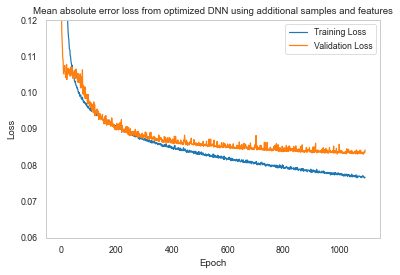

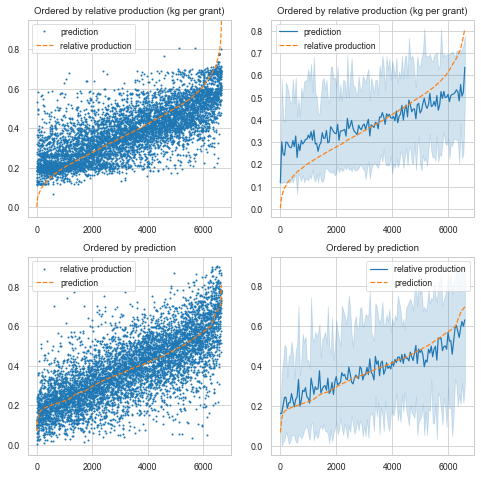

In [20]:
from dense_model import train_simple_dense
logs_name = 'more_features_with_soil_quality'

model, history = train_simple_dense(train_x, train_y, val_x, val_y)
# plot_history(history.history, save_file=f"logs/dnn_loss_{logs_name}.svg")
plot(model, val_x, val_y)


# print("Saving model and history object")
#
# pd.DataFrame(history.history).to_csv(f'logs/history_{logs_name}.csv')
# model.save(f"logs/dnn_model_{logs_name}.keras")

In [21]:
history = pd.read_csv(f'logs/history_{logs_name}.csv')
plot_history(history, save_file=f"logs/dnn_loss_{logs_name}.svg")

model = load_model(f"logs/dnn_model_{logs_name}.keras")
plot(model, val_x, val_y)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/history_more_features_with_soil_quality.csv'